<a href="https://colab.research.google.com/github/SammData/Lab5_Deep_Learning/blob/master/language_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from fastai.text import *

path = "/content/drive/My Drive/DATA-475/imdb"

In [3]:
# create TextLMDataBunch using the csv in path
#     remember to specify the text column
data_lm = TextLMDataBunch.from_csv(
    path,
    "train.csv",
    text_cols="review"
)

In [6]:
# create TextClasDataBunch using the csv in path
#     remember to specify the text/label column
#     specify test dataset, vocab, and bs
data_clas = TextClasDataBunch.from_csv(
    path,
    "train.csv",
    test="test.csv",
    text_cols="review",
    label_cols="sentiment",
    vocab=data_lm.train_ds.vocab,
    bs=32
)

In [8]:
# create language model learner with AWD_LSTM architecture and drop_mult of 0.5
lm_learner = language_model_learner(data_lm,arch=AWD_LSTM, drop_mult=.5)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 6.92E-03


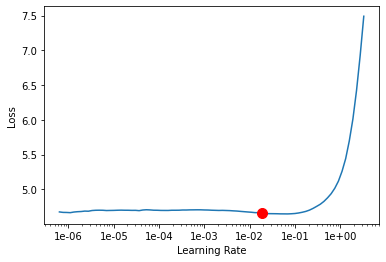

In [9]:
# find a learing rate
lm_learner.lr_find()
lm_learner.recorder.plot(suggestion=True)

In [10]:
# fit one cycle
lr = lm_learner.recorder.min_grad_lr
lm_learner.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.463296,4.254728,0.272939,08:15
1,4.115180,4.047750,0.291080,08:15


In [11]:
# save the encoder
lm_learner.save_encoder("model")

In [12]:
lm_learner.predict("this movie talks about Canadian", n_words=20)

'this movie talks about Canadian Blaxploitation icon John Travolta . Now Travolta has a disgustingly gory , graphic film based'

In [13]:
clas_learner = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
clas_learner.load_encoder("model")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (19999 items)
x: TextList
xxbos a very early xxmaj oliver xxmaj stone ( xxunk film , and one of the first films in the impressive career of xxmaj lloyd xxmaj kaufman ( co - founder and president of the world 's only real independent film studio xxmaj troma , creator of the xxmaj toxic xxmaj avenger and , at the prestigious xxmaj amsterdam xxmaj fantastic xxmaj filmfestival , lifetime - achievement awarded filmmaker for over 30 years ) . xxmaj having raised the money for this film on his own , xxmaj lloyd wrote this script together with xxmaj theodore xxmaj gershuni in 1970 and in hindsight regrets having listened to advice to have xxmaj gershuni else direct the film instead of doing it himself . xxmaj but back then he was still inexperienced in the business and it is probably because of decisions like these that he takes no nonsense from anyone anymore . xxmaj indeed it would have been interesting to see xxmaj lloyd 's version of his

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 5.25E-02


epoch,train_loss,valid_loss,accuracy,time
0,0.436687,0.351367,0.847031,02:34
1,0.438064,0.335719,0.858228,02:26
2,0.410470,0.313616,0.873425,02:38
3,0.397797,0.318966,0.875625,02:40


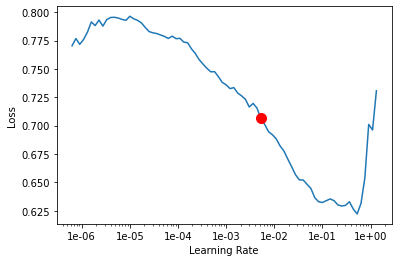

In [14]:
# tune the text_classifier_learner to accpetable accuracy (>80%)
clas_learner.lr_find()
clas_learner.recorder.plot(suggestion=True)
lr = clas_learner.recorder.min_grad_lr
clas_learner.fit_one_cycle(4, lr)

In [15]:
clas_learner.predict("This is a horrible movie.")

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


(Category tensor(1), tensor(1), tensor([0.0368, 0.9632]))

In [16]:
clas_learner.predict("This is a great movie,")

(Category tensor(1), tensor(1), tensor([1.3633e-05, 9.9999e-01]))

In [17]:
# Check the label mapping
# suppose it returns {'negative': 0, 'positive': 1}
data_clas.train_ds.y.c2i

{'negative': 0, 'positive': 1}

In [18]:
import pandas as pd


df = pd.read_csv(path+"/test.csv")
y_true = tensor(df["sentiment"]=="positive")

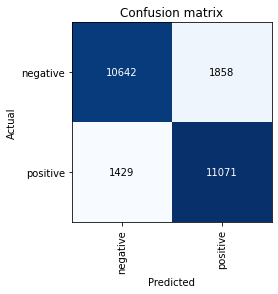

In [19]:
interp = TextClassificationInterpretation.from_learner(
    clas_learner, 
    ds_type=DatasetType.Test
)
interp.y_true = tensor(df["sentiment"]=="positive")
interp.plot_confusion_matrix()

In [20]:
from fastai.metrics import accuracy

accuracy(interp.preds, interp.y_true)

tensor(0.8685)